# Core Workflow: Preparing Ground-truth Files
Transforms the LULC polygons provided by the Atlas of Urban Expansion into raster data that can be combined with imagery and/or other remote sensing inputs to create machine learning training data.

Modified for new architecture in anticipation of Phase IV.  
  
Date: 2019-01-18  
Author: Peter Kerins

### Import statements
(may be over-inclusive)

In [2]:
# typical, comprehensive imports
import warnings
warnings.filterwarnings('ignore')
#
import os
import sys
import json
import itertools
import pickle
from pprint import pprint
#
import numpy as np
import shapely
import cartopy
import geojson
import fiona
import gdal
import h5py
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import ogr, gdal

import collections

import descarteslabs as dl

ULU_REPO = os.environ["ULU_REPO"]
sys.path.append(ULU_REPO+'/utils')
sys.path.append(ULU_REPO)
print(sys.path)

import util_descartes
import util_ml
import util_rasters
import util_vectors
import util_workflow
import util_groundtruth


['/home/Taufiq.Rashid/anaconda3/envs/geoml/lib/python36.zip', '/home/Taufiq.Rashid/anaconda3/envs/geoml/lib/python3.6', '/home/Taufiq.Rashid/anaconda3/envs/geoml/lib/python3.6/lib-dynload', '', '/home/Taufiq.Rashid/anaconda3/envs/geoml/lib/python3.6/site-packages', '/home/Taufiq.Rashid/anaconda3/envs/geoml/lib/python3.6/site-packages/IPython/extensions', '/home/Taufiq.Rashid/.ipython', '/home/Taufiq.Rashid/UrbanLandUse/utils', '/home/Taufiq.Rashid/UrbanLandUse', '/home/Taufiq.Rashid/UrbanLandUse/utils', '/home/Taufiq.Rashid/UrbanLandUse']


### Set key variables

In [2]:
place = 'sitapur'

data_root='/data/phase_iv/'
data_path=data_root+place+'/'

# replace with sentinel-2 ids from the project imagery catalog
# any list of image ids is fine, provided that collectively it covers the full study area
vir_ids = [u'sentinel-2:L1C:2016-01-10_44RMR_83_S2A_v1'] 

tile_resolution = 5
tile_size = 256
tile_pad = 32

# ground truth source: aue, aue+osm, aue+osm2
label_suffix = 'aue'

# NYU AoUE land use/land cover categories
category_label = {0:'Open Space',1:'Non-Residential',\
                   2:'Residential Atomistic',3:'Residential Informal Subdivision',\
                   4:'Residential Formal Subdivision',5:'Residential Housing Project',\
                   6:'Roads',7:'Study Area',8:'Labeled Study Area',254:'No Data',255:'No Label'}

### Load and inspect study area

sitapur Sitapur
>>> ogrinfo -al -so /data/phase_iv/sitapur/Sitapur_studyArea.shp
b'INFO: Open of `/data/phase_iv/sitapur/Sitapur_studyArea.shp\'\n      using driver `ESRI Shapefile\' successful.\n\nLayer name: Sitapur_studyArea\nMetadata:\n  DBF_DATE_LAST_UPDATE=2016-07-18\nGeometry: Polygon\nFeature Count: 1\nExtent: (452962.901712, 3030448.248706) - (484367.511519, 3076769.642552)\nLayer SRS WKT:\nPROJCS["WGS 84 / UTM zone 44N",\n    GEOGCS["WGS 84",\n        DATUM["WGS_1984",\n            SPHEROID["WGS 84",6378137,298.257223563,\n                AUTHORITY["EPSG","7030"]],\n            AUTHORITY["EPSG","6326"]],\n        PRIMEM["Greenwich",0,\n            AUTHORITY["EPSG","8901"]],\n        UNIT["degree",0.0174532925199433,\n            AUTHORITY["EPSG","9122"]],\n        AUTHORITY["EPSG","4326"]],\n    PROJECTION["Transverse_Mercator"],\n    PARAMETER["latitude_of_origin",0],\n    PARAMETER["central_meridian",81],\n    PARAMETER["scale_factor",0.9996],\n    PARAMETER["false_easting"

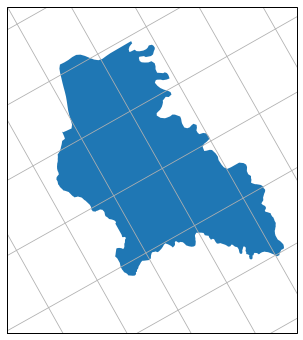

In [3]:
print(place, place.title()) # capitalized version of place name
place_title = place.title()
place_shapefile = data_path+place_title+"_studyAreaEPSG4326.shp"

util_vectors.info_studyareas(data_path, place)

shape = util_vectors.load_shape(place_shapefile)
polygon = shape['geometry']['coordinates']
# print(polygon)
# pprint(shape)
place_bbox = shape['bbox']
# print(bbox)

# using Albers projection
lonlat_crs = cartopy.crs.PlateCarree()
clat, clon = (place_bbox[0]+place_bbox[2])/2.0, (place_bbox[1]+place_bbox[3])/2.0
print("center co-ordinates", clat, clon)
albers = cartopy.crs.AlbersEqualArea(central_latitude=clat, central_longitude=clon)

# visualize Study Region
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(projection=albers) # Specify projection of the map here
shp = shapely.geometry.shape(shape['geometry'])
ax.add_geometries([shp], lonlat_crs)
ax.set_extent((place_bbox[0], place_bbox[2], place_bbox[1], place_bbox[3]), crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)
plt.show()

### Generate tiles

number of tiles to cover region 587
dict_keys(['geometry', 'type', 'properties'])
tile022 {
  'coordinates': [[[80.54417672689733, 27.654738923241645], [80.56039780033113, 27.6547913102528], [80.56034001206851, 27.669235266940337], [80.54411680645714, 27.669182847947447], [80.54417672689733, 27.654738923241645]]],
  'type': 'Polygon'
}


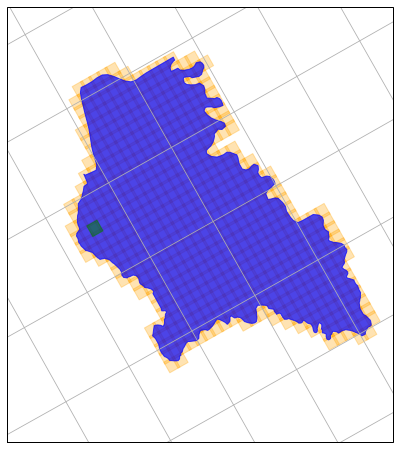

In [4]:
tiles = dl.raster.dltiles_from_shape(tile_resolution, tile_size, tile_pad, shape)
single_tile_id = 22
highlights = {single_tile_id:'green'}
util_vectors.draw_tiled_area(shape, tiles, albers, lonlat_crs, highlights=highlights)

### Create ground-truth raster tiles
For each tile, creates a blank GeoTiff file and subsequently "burns" into it values from the (already prepared) GeoJSON file holding the AUE LULC polygons, thereby "rasterizing" the vector ground-truth data into a format amenable to machine learning: individual pixels in imagery can now be associated with specific LULC categories.

In [5]:
for tile_id in range(len(tiles['features'])):
    tile = tiles['features'][tile_id]
    util_groundtruth.make_label_raster(data_path, place, tile_id, tile, vir_ids, shape,
        label_suffix='aue', vector_format='geojson', burn_attribute="Land_use")

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0000_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0000_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0001_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0001_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0002_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0002_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0003_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /dat

>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0029_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0030_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0030_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0031_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0031_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0032_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0032_lulc.tif
b'0...10

>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0059_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0060_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0060_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0061_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0061_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0062_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0062_lulc.tif
b'0...10

>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0089_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0090_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0090_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0091_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0091_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0092_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0092_lulc.tif
b'0...10

>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0119_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0120_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0120_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0121_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0121_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0122_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0122_lulc.tif
b'0...10

>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0149_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0150_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0150_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0151_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0151_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0152_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0152_lulc.tif
b'0...10

>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0179_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0180_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0180_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0181_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0181_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0182_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0182_lulc.tif
b'0...10

>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0209_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0210_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0210_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0211_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0211_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0212_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0212_lulc.tif
b'0...10

>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0239_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0240_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0240_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0241_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0241_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0242_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0242_lulc.tif
b'0...10

>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0269_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0270_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0270_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0271_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0271_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0272_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0272_lulc.tif
b'0...10

>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0299_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0300_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0300_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0301_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0301_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0302_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0302_lulc.tif
b'0...10

>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0329_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0330_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0330_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0331_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0331_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0332_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0332_lulc.tif
b'0...10

>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0359_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0360_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0360_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0361_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0361_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0362_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0362_lulc.tif
b'0...10

>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0389_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0390_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0390_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0391_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0391_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0392_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0392_lulc.tif
b'0...10

>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0419_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0420_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0420_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0421_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0421_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0422_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0422_lulc.tif
b'0...10

>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0449_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0450_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0450_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0451_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0451_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0452_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0452_lulc.tif
b'0...10

>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0479_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0480_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0480_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0481_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0481_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0482_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0482_lulc.tif
b'0...10

>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0509_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0510_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0510_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0511_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0511_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0512_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0512_lulc.tif
b'0...10

>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0539_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0540_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0540_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0541_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0541_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0542_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0542_lulc.tif
b'0...10

>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0569_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0570_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0570_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0571_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0571_lulc.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0572_lulc
>>> gdal_rasterize -a Land_use /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0572_lulc.tif
b'0...10

In [6]:
for tile_id in range(len(tiles['features'])):
    tile = tiles['features'][tile_id]
    util_groundtruth.make_label_raster(data_path, place, tile_id, tile, vir_ids, shape,
        label_suffix='aue', vector_format='geojson', burn_attribute='Locale_No')

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0000_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0000_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0001_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0001_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0002_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0002_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0003_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Com

>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0029_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0030_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0030_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0031_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0031_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0032_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0032_l

>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0058_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0059_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0059_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0060_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0060_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0061_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0061_l

>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0087_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0088_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0088_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0089_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0089_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0090_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0090_l

>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0116_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0117_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0117_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0118_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0118_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0119_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0119_l

>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0145_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0146_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0146_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0147_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0147_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0148_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0148_l

>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0174_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0175_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0175_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0176_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0176_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0177_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0177_l

>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0203_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0204_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0204_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0205_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0205_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0206_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0206_l

>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0232_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0233_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0233_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0234_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0234_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0235_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0235_l

>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0261_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0262_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0262_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0263_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0263_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0264_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0264_l

>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0290_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0291_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0291_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0292_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0292_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0293_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0293_l

>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0319_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0320_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0320_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0321_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0321_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0322_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0322_l

>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0348_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0349_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0349_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0350_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0350_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0351_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0351_l

>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0377_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0378_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0378_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0379_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0379_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0380_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0380_l

>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0406_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0407_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0407_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0408_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0408_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0409_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0409_l

>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0435_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0436_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0436_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0437_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0437_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0438_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0438_l

>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0464_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0465_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0465_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0466_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0466_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0467_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0467_l

>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0493_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0494_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0494_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0495_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0495_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0496_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0496_l

>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0522_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0523_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0523_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0524_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0524_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0525_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0525_l

>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0551_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0552_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0552_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0553_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0553_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0554_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0554_l

>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0580_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0581_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0581_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0582_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0582_locale.tif
b'0...10...20...30...40...50...60...70...80...90...100 - done.\n' 

imgfile /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0583_locale
>>> gdal_rasterize -a Locale_No /data/phase_iv/sitapur/gt/Sitapur_Complete.geojson /data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0583_l

[[255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
0 2742 Open Space
1 278 Non-Residential
3 292 Residential Informal Subdivision
6 271 Roads
255 98817 No Label


{0: 2742, 1: 278, 3: 292, 6: 271, 255: 98817}

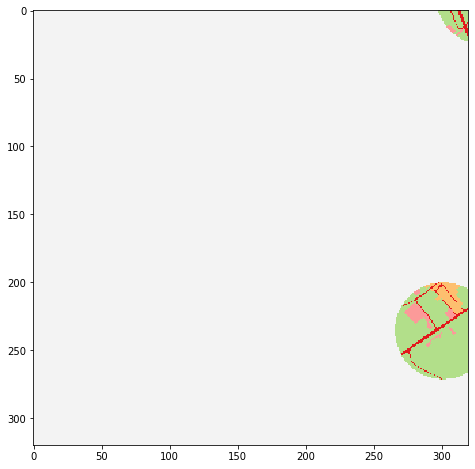

In [3]:
path = '/data/phase_iv/sitapur/gt/sitapur_aue0_5m_p32_tile0176_lulc.tif'
lulc,_,_,_,_ = util_rasters.load_geotiff(path)
print(lulc)

category_label={0:'Open Space',1:'Non-Residential',\
                   2:'Residential Atomistic',3:'Residential Informal Subdivision',\
                   4:'Residential Formal Subdivision',5:'Residential Housing Project',\
                   6:'Roads',7:'Study Area',8:'Labeled Study Area',254:'No Data',255:'No Label'}

util_rasters.stats_byte_raster(path, category_label, show=True)